In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, utils, optimizers
import matplotlib.pyplot as plt
from PIL.ImageOps import invert
from PIL import Image

### Load Data
We will start by loading the data into a Pandas dataframe.  Pandas will be useful to explore the data.
<br> The data has already been split for us into a training and testing set.  The training set will be used to train the model, and the testing set will be used to test the accuracy of the model on data it was not trained on.

In [25]:
train = pd.read_csv('data/fashion-mnist_train.csv')
test = pd.read_csv('data/fashion-mnist_test.csv')

### Exploratory Data Analysis
First we'll start by looking at the head of the data.
<br>Each row in the data represents a 28 x 28 image, with its pixels flattened to a single row.
<br>The labels correspond to the type of item shown in the image.

In [42]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
train.groupby(['label']).plot()

We will create a dictionary to translate the numeric labels to human readable text

In [22]:
labels = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
          5: 'Sandal',      6: 'Shirt',   7: 'Sneaker',  8: 'Bag',   9: 'Ankle Boot'}

The labels and the data are all in one array.  We'll start by splitting these into two separate parts.
We'll also convert everything into a Numpy array as it will be easier to use this data format in the next steps.

In [31]:
X_train = np.array(train.drop(columns=['label']))
X_test = np.array(test.drop(columns=['label']))

y_train = np.array(train['label'])
y_test = np.array(test['label'])

In [34]:
max(X_train)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### Normalize Data
We are planning to train a convocational neural network (CNN) on this data, when training a CNN, they can learn faster if the values of the data are between 0 and 1.  We will accomplish this by dividing all values by 255 -- the largest value a pixel can have.

In [37]:
train.max().max()

255

In [38]:
X_train = X_train / 255
X_test = X_test / 255

### Reshape Data
CNN's use the position of the data in the array to learn with context so we will reshape the data to be a 2d array
<br> We will be using a Softmax layer for output.  Softmax is useful because it will give us the confidence the network has for its prediction.  To use softmax, the targets must be categorical.
- 0 becomes [1,0,0,0,0,0,0,0,0,0]
- 1 becomes [0,1,0,0,0,0,0,0,0,0]
- and so on

In [104]:
X_train = np.reshape(X_train, (X_train.shape[0], 28,28, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 28,28, 1))

y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)

In [28]:
train.shape

(60000, 785)

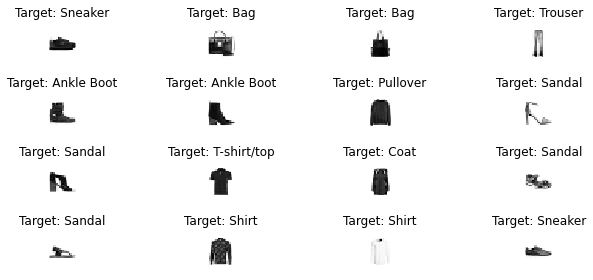

In [108]:
rows = 4
columns = 4
fig, axs = plt.subplots(rows,columns, figsize=(10, 4))
indx = 1
for i in range(rows):
    for j in range(columns):
        axs[i,j].imshow(X_train[indx], interpolation='nearest', cmap='Greys')
        axs[i,j].axis('off')
        axs[i,j].autoscale(False)
        axs[i,j].title.set_text(f'Target: {labels[y_train[indx].argmax()]}')
        indx += 1
plt.tight_layout()
plt.show()

In [23]:
def augment(train, test):
    """Generate more training data by creating different sized images."""
    new_train = train
    new_test = test
    scales = [21, 18]
    for scale in scales:
        new = tf.image.resize(train, [scale, scale])
        new = tf.image.resize_with_crop_or_pad(new, 28, 28)
        new_train = np.append(new_train, new, axis = 0)
        new_test = np.append(new_test, test, axis = 0)

    new_train = np.append(new_train, np.flip(new_train, axis=2), axis = 0)
    new_test = np.append(new_test, new_test, axis = 0)

    return new_train, new_test

In [ ]:
X_train, y_train = augment(X_train, y_train)
X_test, y_test = augment(X_test, y_test)

In [109]:
model = models.Sequential()

model.add(layers.Conv2D(32, 3, activation='relu', input_shape=(28,28, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))


model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.BatchNormalization())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [110]:
history = model.fit(X_train, y_train, epochs=5,
                    batch_size = 128,
                    validation_data=(X_test, y_test))

Epoch 1/5
2813/2813 [==============================] - 376s 133ms/step - loss: 0.4452 - accuracy: 0.8358 - val_loss: 0.2767 - val_accuracy: 0.8978
Epoch 2/5
2813/2813 [==============================] - 390s 139ms/step - loss: 0.3158 - accuracy: 0.8842 - val_loss: 0.2688 - val_accuracy: 0.8993
Epoch 3/5
2813/2813 [==============================] - 394s 140ms/step - loss: 0.2835 - accuracy: 0.8968 - val_loss: 0.2358 - val_accuracy: 0.9097
Epoch 4/5
2813/2813 [==============================] - 354s 126ms/step - loss: 0.2646 - accuracy: 0.9033 - val_loss: 0.2351 - val_accuracy: 0.9122
Epoch 5/5
2813/2813 [==============================] - 362s 129ms/step - loss: 0.2523 - accuracy: 0.9078 - val_loss: 0.2197 - val_accuracy: 0.9191


In [21]:
def process_image(image):
    # pad image to be square
    width, height = image.size
    if width == height:
        square = image
    elif width > height:
        square = Image.new(image.mode, (width, width), (255,255,255))
        square.paste(image, (0, (width - height) // 2))
    else:
        square = Image.new(image.mode, (height, height), (255,255,255))
        square.paste(image, ((height - width) // 2, 0))
    image = square

    image = image.resize((28,28)) # resize to 28 by 28
    image = image.convert('L') # convert to black and white
    image = invert(image) # invert color

    image = np.array(image) # convert to numpy array
    image = image / 255 # normalize values to be between 0 and 1
    image = (image-np.min(image)) / (np.max(image)-np.min(image)) # maximize contrast
    image = np.reshape(image, (1, 28, 28, 1)) # reshape

    return image

Pullover


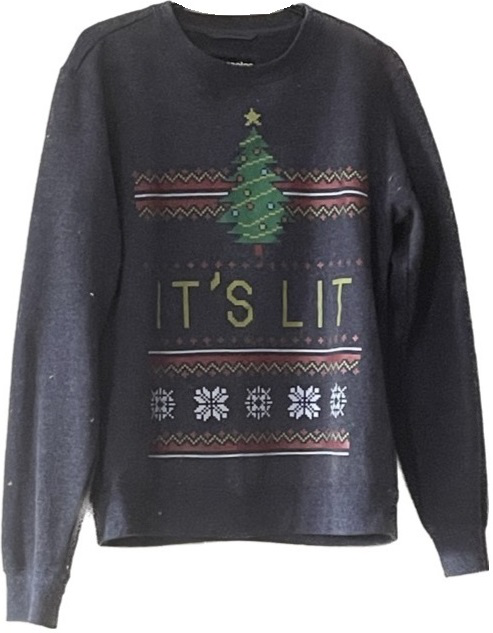

T-shirt/top: 0.13%
Trouser: 0.02%
Pullover: 63.55%
Dress: 0.04%
Coat: 24.14%
Sandal: 0.0%
Shirt: 12.1%
Sneaker: 0.0%
Bag: 0.01%
Ankle Boot: 0.0%


In [19]:
image = Image.open('data/pullover.jpg')
processed_image = process_image(image)
pred = model.predict(processed_image)[0]
print(labels[pred.argmax()])
display(image)
for i, confidence in enumerate(pred):
    print('{}: {}%'.format(labels[i], round(confidence*100,2)))

Ankle Boot


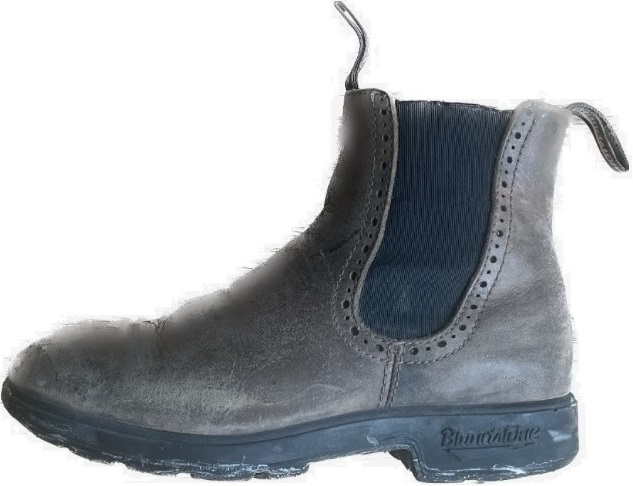

T-shirt/top: 0.0%
Trouser: 0.0%
Pullover: 0.0%
Dress: 0.0%
Coat: 0.0%
Sandal: 0.0%
Shirt: 0.0%
Sneaker: 0.11%
Bag: 0.0%
Ankle Boot: 99.89%


In [20]:
image = Image.open('data/boot.jpg')
processed_image = process_image(image)
pred = model.predict(processed_image)[0]
print(labels[pred.argmax()])
display(image)
for i, confidence in enumerate(pred):
    print('{}: {}%'.format(labels[i], round(confidence*100,2)))

In [7]:
model.save('model')
converter =tf.lite.TFLiteConverter.from_saved_model('model')
tflite_model = converter.convert()

with open('../Backend/model.tflite', 'wb') as f:
    f.write(tflite_model)